# Predator-Prey Dynamics Based on Bode (2005)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

In [50]:
N_0 = 100
K = 250
r = 1.3 # values between 0 and 1. If at 1, population doubles at each time step

P_0 = 10
C_b = 3
C_d = 1
C_max = 10

time = 60
N = [N_0]
P = [P_0]
catch_history = []
catch = [0]
#Prey dynamics
for t in range(1,time):
    N_next = r*N[t-1]*( 1-N[t-1]/K ) - N[t-1]*P[t-1]
    N_next = round(N_next)

    catch = [round(random.uniform(0,(C_max*N_next)/K)) for _ in range(P[t-1])]
    catch_history.append(catch)
    b = sum([1 if c >= C_b else 0 for c in catch])
    d = sum([1 if c <= C_d else 0 for c in catch])
    P_next = P[t-1] + b - d

    P.append(P_next)
    N.append(N_next - sum(catch))
    pass

plt.plot(N, label = 'prey')
plt.plot(P, label='predator')
plt.legend()
plt.show()

OverflowError: cannot convert float infinity to integer

# Use professor bode's code

In [51]:
zzd = 1

N_0 = 20
a = 0.01
K = 100
r = 1.3 # values between 0 and 1. If at 1, population doubles at each time step

P_0 = 10
b = 0.08
mu = 0.1

sigma = 0.05

time = 200
N = [N_0]
P = [P_0]
catch_history = []
catch = [0]
extinct = []
#Prey dynamics
for _ in range(1,1000):
    for t in range(1,time):
        Z = [random.lognormvariate(0,sigma=sigma), random.lognormvariate(0,sigma=sigma)]

        N_next = r*N[t-1]*(1-N[t-1]/K) - a*N[t-1]*P[t-1]
        N_next = round(N_next)

        P_next = b*P[t-1]*N[t-1] - mu*P[t-1]

        P.append(Z[0]*P_next)
        N.append(Z[1]*N_next)

        if N[t] < d or P[t] < d:
            extinct.append(len(N))
            break
        if t == time:

            break
        pass

In [53]:
class PredatorPrey:
    def __init__(self):
        self.extinct = []
        self.N_list = []
        self.P_list = []
        pass

    def run(self,
            d=1,
            N_0=20,
            a=0.01,
            K=100,
            r=1.3,
            P_0=10,
            b=0.08,
            mu=0.1,
            sigma=0.05,
            time=200,
            finite = True):

        N = [N_0]
        P = [P_0]
        if finite:
            for t in range(1, time):
                # stochasticity
                Z_N = random.lognormvariate(0, sigma)
                Z_P = random.lognormvariate(0, sigma)

                # prey update
                N_next = r*N[t-1]*(1 - N[t-1] / K) - a*N[t-1]*P[t-1]
                N_next = round(N_next)

                # predator update
                P_next = b*P[t-1]*N[t-1] - mu*P[t-1]

                N.append(Z_N * N_next)
                P.append(Z_P * P_next)

                # extinction check
                if N[t] < d or P[t] < d:
                    self.extinct.append(len(N))
                    break
            self.N_list.append(N)
            self.P_list.append(P)
        else:
            stop = False
            t = 0
            while stop == False:
                t += 1
                Z_N = random.lognormvariate(0, sigma)
                Z_P = random.lognormvariate(0, sigma)

                # prey update
                N_next = r*N[t-1]*(1 - N[t-1] / K) - a*N[t-1]*P[t-1]

                # predator update
                P_next = b*P[t-1]*N[t-1] - mu*P[t-1]

                N.append(round(Z_N * N_next))
                P.append(round(Z_P * P_next))

                # extinction check
                if N[t] < d or P[t] < d:
                    self.extinct.append(len(N))
                    stop = True       
            self.N_list.append(N)
            self.P_list.append(P)

    def plot(self, i=None):
        if i == None:
            i=len(self.N_list)-1
        else:  
            i=i
        plt.plot(self.N_list[i], label = 'prey')
        plt.plot(self.P_list[i], label='predator')
        plt.legend()
        plt.show()

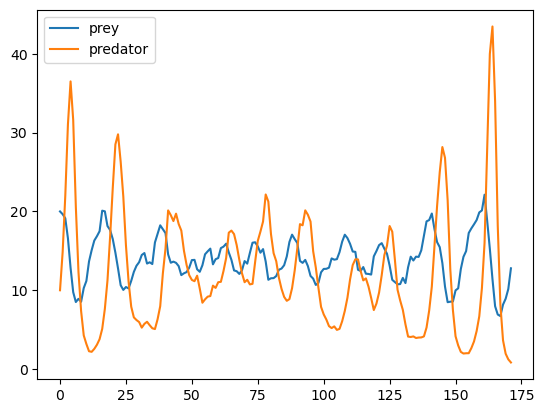

In [62]:
sim = PredatorPrey()
sim.run()
sim.plot()

In [70]:
for _ in range(1000):
    sim.run(finite=False)

In [71]:
print(f'Average is: {np.mean(sim.extinct)}')
print(f'Mode is: {stats.mode(sim.extinct)[0]}')
print(f'Maximum is: {np.max(sim.extinct)}')
print(f'Minimum is: {np.min(sim.extinct)}')
print(f'Squared Variance is: {np.sqrt((np.var(sim.extinct, ddof = 1)))}')
print(f'Kurtosis is : {stats.kurtosis(sim.extinct)}')

Average is: 22617.488759367196
Mode is: 11
Maximum is: 158809
Minimum is: 11
Squared Variance is: 22462.013030449474
Kurtosis is : 4.872958673108657


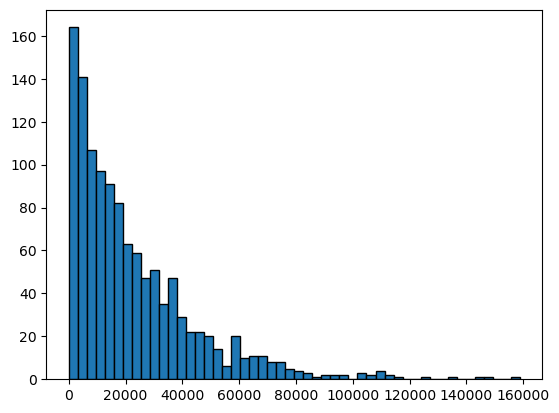

In [72]:
plt.hist(sim.extinct, bins = 50, edgecolor = 'black')
plt.show()

# Now Do SDP Section

In [ ]:
class PredatorPreySDP:
    def __init__(self, N_max = 40, P_max=30):
        self.extinct = []
        self.N_list = []
        self.P_list = []
        self.S_mat = np.array([[n,p] for n in range(N_max+1) for p in range(P_max+1)], dtype=float)
        self.num_states = self.S_mat.shape[0]
        self.T_mat = np.zeros((self.num_states,self.num_states),dtype=float)
        self.T_N = np.zeros((self.num_states,self.num_states),dtype=float)
        self.T_P = np.zeros((self.num_states,self.num_states),dtype=float)
        self.N_max = N_max
        self.P_max = P_max
        pass

    def run(
            self,
            mat: np.array, #T_mat or T_N
            d=1,
            a=0.01,
            K=100,
            r=1.3,
            b=0.08,
            mu=0.1,
            sigma=0.05,
            time=200,
            sims = 1,
            finite = True,
            cull:str = 'none',
            N_cull:int = 5,
            P_cull:int = 5,
        ):
        """
        d - Minimum value of the population. If below d, pop will extinct
        a - 

        cull = ['none', 'prey','predator']
        """
        state_f_ind = 0
        state_i_ind = 0
        if finite:
            for _ in range(sims):
                for i in range(self.num_states):
                    N = [self.S_mat[i,0]]
                    P = [self.S_mat[i,1]]

                    for t in range(1, time):
                        # Begin starting index for T matrix
                        state_i_ind = np.where(np.all(self.S_mat == np.array([N[-1], P[-1]]), axis=1))[0][0]

                        # Create stochasticity
                        Z_N = random.lognormvariate(0, sigma)
                        Z_P = random.lognormvariate(0, sigma)

                        # prey update
                        N_next = r*N[t-1]*(1 - N[t-1] / K) - a*N[t-1]*P[t-1]

                        # predator update
                        P_next = b*P[t-1]*N[t-1] - mu*P[t-1]

                        if cull == 'prey':
                            N_next = N_next - N_cull

                        if cull == 'predator':
                            P_next = P_next - P_cull

                        N.append(round(min(Z_N * N_next, self.N_max)))
                        P.append(round(min(Z_P * P_next, self.P_max)))

                        # extinction check
                        if N[t] < d or P[t] < d:
                            if N[t] < d: N[t] = 0
                            if P[t] < d: P[t] = 0
                            state_f_ind = np.where(np.all(self.S_mat == np.array([N[-1], P[-1]]), axis=1))[0][0]

                            # Update
                            mat[state_i_ind,state_f_ind] += 1

                            self.extinct.append(len(P))
                            break
                        
                        # maximum check
                        if N[t] > self.N_max or P[t] > self.P_max:
                            if N[t] > self.N_max: N[t] = self.N_max
                            if P[t] > self.P_max: P[t] = self.P_max

                            # Find final index and update T matrix
                            state_f_ind = np.where(np.all(self.S_mat == np.array([N[-1], P[-1]]), axis=1))[0][0]
                            mat[state_i_ind,state_f_ind] += 1
                            break
                        
                        # Find final index and update
                        state_f_ind = np.where(np.all(self.S_mat == np.array([N[-1], P[-1]]), axis=1))[0][0] 
                        mat[state_i_ind,state_f_ind] += 1

                    self.N_list.append(N)
                    self.P_list.append(P)
        else:
            stop = False
            t = 0
            while stop == False:
                for _ in range(sims):
                    t += 1
                    for i in range(self.num_states):
                        N = [self.S_mat[i,0]]
                        P = [self.S_mat[i,1]]

                        for t in range(1, time):
                            # Begin starting index for T matrix
                            state_i_ind = np.where(np.all(self.S_mat == np.array([round(N[-1]), round(P[-1])]), axis=1))[0][0]

                            # Create stochasticity
                            Z_N = random.lognormvariate(0, sigma)
                            Z_P = random.lognormvariate(0, sigma)

                            # prey update
                            N_next = r*N[t-1]*(1 - N[t-1] / K) - a*N[t-1]*P[t-1]

                            # predator update
                            P_next = b*P[t-1]*N[t-1] - mu*P[t-1]

                            N.append(min(Z_N * N_next, self.N_max))
                            P.append(min(Z_P * P_next, self.P_max))

                            # extinction check
                            if N[t] < d or P[t] < d:
                                if N[t] < d: N[t] = 0
                                if P[t] < d: P[t] = 0
                                state_f_ind = np.where(np.all(self.S_mat == np.array([round(N[-1]), round(P[-1])]), axis=1))[0][0]

                                # Update
                                mat[state_i_ind,state_f_ind] += 1

                                self.extinct.append(len(P))
                                break
                            
                            # maximum check
                            if N[t] > self.N_max or P[t] > self.P_max:
                                if N[t] > self.N_max: N[t] = self.N_max
                                if P[t] > self.P_max: P[t] = self.P_max

                                # Find final index and update T matrix
                                state_f_ind = np.where(np.all(self.S_mat == np.array([round(N[-1]), round(P[-1])]), axis=1))[0][0]
                                mat[state_i_ind,state_f_ind] += 1
                                break
                            
                            # Find final index and update
                            state_f_ind = np.where(np.all(self.S_mat == np.array([round(N[-1]), round(P[-1])]), axis=1))[0][0] 
                            mat[state_i_ind,state_f_ind] += 1

                        self.N_list.append(N)
                        self.P_list.append(P)

    def mat_normalize(self,mat):
        row_sums = mat.sum(axis=1, keepdims=True)
        return np.divide(mat, row_sums, where=row_sums!=0)

    def sdp(self, t_max:int = 250, prey:bool = False):
        self.t_max = t_max
        V = self.S_mat**2

        V[:,0] = V[:,0]/max(V[:,0])
        V[:,1] = V[:,1]/max(V[:,1])
        V = V.sum(axis=1) # terminal value 

        self.A_mat = np.zeros((self.num_states, self.t_max), dtype=int)
        # Backward iteration
        for t in range(self.t_max):
            if prey:
                cull = np.column_stack((self.T_mat @ V, self.T_N @ V, self.T_P @ V))
            else:
                cull = np.column_stack((self.T_mat @ V, self.T_N @ V))

            V = np.max(cull, axis=1)
            self.A_mat[:, self.t_max - t -1] = np.argmax(cull,axis=1)

    def plot(self, i=None):
        if i == None:
            i=len(self.N_list)-1
        else:  
            i=i
        plt.plot(self.N_list[i], label = 'prey')
        plt.plot(self.P_list[i], label='predator')
        plt.legend()
        plt.show()

    def plot_sdp(self):
        '''
        Plot an optimal culling strategy
        0 - No cull
        1 - Cull predator
        2 - Cull prey
        '''
        image_mat = np.zeros((self.N_max, self.P_max))

        for i in range(self.num_states):
            n = int(self.S_mat[i, 0])
            p = int(self.S_mat[i, 1])
            image_mat[n-1, p-1] = self.A_mat[i, 0]

        plt.figure(figsize=(8, 6))
        plt.pcolor(np.arange(self.N_max+1), np.arange(self.P_max+1), image_mat.T, shading='auto')
        plt.colorbar(label="Action")
        plt.xlabel("N")
        plt.ylabel("P")
        plt.title("Optimal Action Map")
        plt.show()

# Applied Case

In [62]:
sim = PredatorPreySDP(N_max = 40, P_max = 30)
sim.run(sims=300, mat = sim.T_mat, time = 3)
sim.run(sims=300, mat = sim.T_N, time = 3,cull = 'prey')
sim.run(sims = 300, mat = sim.T_P, time = 3, cull='predator')

sim.T_mat = sim.mat_normalize(sim.T_mat)
sim.T_N = sim.mat_normalize(sim.T_N)
sim.T_P = sim.mat_normalize(sim.T_P)

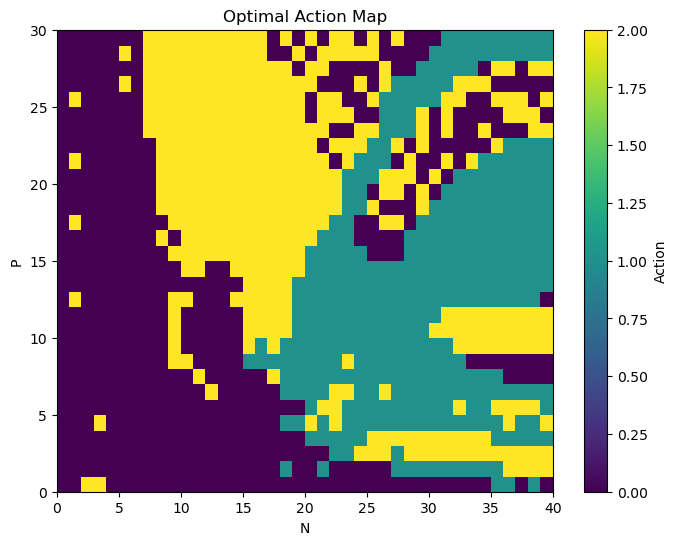

In [68]:
sim.sdp(prey = True)
sim.plot_sdp()

# A more customizable SDP

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class PredatorPreySDP:
    """
    Discrete predator-prey ODE simulation with stochastic noise and a stochastic dynamic programming component

    Attributes:
        extinct (dict): Dictionary to store extinction times for managed and unmanaged populations
        ext_mats (dict): Matrices to store extinction counts and times
        N_list (dict): Lists to store prey population trajectories for managed and unmanaged populations
        P_list (dict): Lists to store predator population trajectories for managed and unmanaged populations
        S_mat (np.array): State matrix containing all possible population states
        num_states (int): Number of states in the state matrix
        T_mats (dict): Transition matrices for different culling strategies
        N_max (int): Maximum prey population
        P_max (int): Maximum predator population
    """
    def __init__(self, N_max = 40, P_max=30):
        """
        Initialize an instance
        
        :param N_max: The maximum prey population
        :param P_max: The maximum predator population
        """
        self.extinct = {'managed':[], 'unmanaged':[]}
        self.ext_mats = None
        self.N_list = {'managed':[], 'unmanaged':[]}
        self.P_list = {'managed':[], 'unmanaged':[]}
        self.S_mat = np.array([[n,p] for n in range(N_max+1) for p in range(P_max+1)], dtype=float)
        self.num_states = self.S_mat.shape[0]
        self.T_mats = {}
        self.N_max = N_max
        self.P_max = P_max
        pass

    def run(
            self,
            d=2,
            a=0.01,
            K=100,
            r=1.3,
            b=0.08,
            mu=0.1,
            sigma=0.05,
            matrix_name:str = None,
            time=200,
            sims = 1,
            cull:str = 'none',
            N_cull:int = 5,
            P_cull:int = 5,
        ) -> None:
        """
        Run simulations to build transition matrix

        :param d: Extinction threshold
        :param a: Predator hunt success rate
        :param K: Prey carrying capacity
        :param r: Prey growth rate
        :param b: Predator birth rate, based on prey abundance
        :param mu: Predator mortality rate
        :param sigma: Environmental stochasticity
        :param matrix_name: Name of the transition matrix, suggested T Matrix, T N Matrix 1, etc.
        :param time: Maximum time steps per simulation
        :param sims: Number of simulations per state
        :param cull: Type of culling ('prey', 'predator', 'none')
        :param N_cull: Number of prey to cull if culling prey
        :param P_cull: Number of predators to cull if culling predators
        """
        state_f_ind = 0
        state_i_ind = 0
        mat = np.zeros((self.num_states,self.num_states),dtype=float) # Set matrix, may be anything
        for _ in range(sims):
            for i in range(self.num_states):
                N = [self.S_mat[i,0]]
                P = [self.S_mat[i,1]]

                for t in range(1, time):
                    # Begin starting index for T matrix
                    state_i_ind = np.where(np.all(self.S_mat == np.array([N[-1], P[-1]]), axis=1))[0][0]

                    # Create stochasticity
                    Z_N = random.lognormvariate(0, sigma)
                    Z_P = random.lognormvariate(0, sigma)

                    # prey update
                    N_next = r*N[t-1]*(1 - N[t-1] / K) - a*N[t-1]*P[t-1]

                    # predator update
                    P_next = b*P[t-1]*N[t-1] - mu*P[t-1]

                    if cull == 'prey':
                        N_next = N_next - N_cull

                    if cull == 'predator':
                        P_next = P_next - P_cull

                    N.append(round(min(Z_N * N_next, self.N_max)))
                    P.append(round(min(Z_P * P_next, self.P_max)))

                    # extinction check
                    if N[t] < d or P[t] < d:
                        if N[t] < d: N[t] = 0
                        if P[t] < d: P[t] = 0
                        state_f_ind = np.where(np.all(self.S_mat == np.array([N[-1], P[-1]]), axis=1))[0][0]

                        # Update
                        mat[state_i_ind,state_f_ind] += 1
                        break
                    
                    # maximum check
                    if N[t] > self.N_max or P[t] > self.P_max:
                        if N[t] > self.N_max: N[t] = self.N_max
                        if P[t] > self.P_max: P[t] = self.P_max

                        # Find final index and update T matrix
                        state_f_ind = np.where(np.all(self.S_mat == np.array([N[-1], P[-1]]), axis=1))[0][0]
                        mat[state_i_ind,state_f_ind] += 1
                        break
                    
                    # Find final index and update
                    state_f_ind = np.where(np.all(self.S_mat == np.array([N[-1], P[-1]]), axis=1))[0][0] 
                    mat[state_i_ind,state_f_ind] += 1
                
                self.T_mats[matrix_name] = mat
        for mat in self.T_mats:
            self.T_mats[mat] = self.mat_normalize(self.T_mats[mat])

    def mat_normalize(self,mat) -> np.array:
        """
        Normalize a matrix by row sums
        
        :param mat: Matrix to normalize
        """
        row_sums = mat.sum(axis=1, keepdims=True)
        return np.divide(mat, row_sums, where=row_sums!=0)
    
    def sdp_economic(self, c_base, base_price, t_max:int = 250)-> None:
        R_mat = np.zeros((self.num_states,len(list(self.T_mats.items())))) # 10 population states, 5 harvest levels (0-4)

        for i in range(self.num_states):
            N_i =  float(self.S_mat[i,0])
            v_scarce = 1 + (1 - N_i/self.N_max)  # Scarcity multiplier increases as population decreases
            for j in range(0,len(list(self.T_mats.items()))):
                # R_i,j = Harvest_j * Base_Price * V_scarcity(N_i) - Cost_j
                # We apply the scarcity multiplier (V_scarcity) to the base price
                if N_i == 0:
                    R_mat[i, j] = 0
                    continue
                harv_rev = base_price * v_scarce
                harv_cost = c_base * j
                R_mat[i, j] = harv_rev - harv_cost

        V = self.S_mat**2
        self.t_max = t_max

        V[:,0] = V[:,0]/max(V[:,0])
        V[:,1] = V[:,1]/max(V[:,1])
        V = V.sum(axis=1) # terminal value 

        self.A_mat = np.zeros((self.num_states, self.t_max), dtype=int)
        
        for t in range(self.t_max):
            for i in range(len(list(self.T_mats.items()))):
                # Calculate Future Value (Expected Value of next state)
                future_val = list(self.T_mats.items())[i][1] @ V
                
                # Add Immediate Economic Reward (R_mat) to Future Value
                # This is the "Economic Incentive" step
                total_val = R_mat[:, i] + future_val

                if i == 0:
                    tup = (total_val,)
                else:
                    tup = tup + (total_val,)
            
            cull = np.column_stack(tup)

            V = np.max(cull, axis=1)
            self.A_mat[:, self.t_max - t -1] = np.argmax(cull,axis=1)
    
        # Save Policy Matrix
        self.P_mat = np.zeros((self.N_max, self.P_max))

        for i in range(self.num_states):
            n = int(self.S_mat[i, 0])
            p = int(self.S_mat[i, 1])
            self.P_mat[n-1, p-1] = self.A_mat[i, 0]

    def sdp(self, value:str = 'quadratic', t_max:int = 250)-> None:
        """
        Perform stochastic dynamic programming to find optimal culling strategy
        :param value: Type of terminal value function ('quadratic', 'linear', 'economics')
        :param t_max: Maximum time horizon
        """
        V = self.S_mat**2
        self.t_max = t_max

        V[:,0] = V[:,0]/max(V[:,0])
        V[:,1] = V[:,1]/max(V[:,1])
        V = V.sum(axis=1) # terminal value 

        self.A_mat = np.zeros((self.num_states, self.t_max), dtype=int)
        # Backward iteration
        for t in range(self.t_max):
            for i in range(len(list(self.T_mats.items()))):
                if i == 0:
                    tup = (list(self.T_mats.items())[i][1] @ V,)
                else:
                    tup = tup + (list(self.T_mats.items())[i][1] @ V,)
            cull = np.column_stack(tup)

            V = np.max(cull, axis=1)
            self.A_mat[:, self.t_max - t -1] = np.argmax(cull,axis=1)
        
        # Save Policy Matrix
        self.P_mat = np.zeros((self.N_max, self.P_max))

        for i in range(self.num_states):
            n = int(self.S_mat[i, 0])
            p = int(self.S_mat[i, 1])
            self.P_mat[n-1, p-1] = self.A_mat[i, 0]
        
    def reset_lists(self) -> None:
        """
        Reset the lists used to store population trajectories and extinction times
        """
        self.extinct = {'managed':[], 'unmanaged':[]}
        self.ext_mats = None
        self.N_list = {'managed':[], 'unmanaged':[]}
        self.P_list = {'managed':[], 'unmanaged':[]}

    def model_pop(
            self,
            cull:bool = True,
            N_0 = None,
            P_0 = None,
            d=2,
            a=0.01,
            K=100,
            r=1.3,
            b=0.08,
            mu=0.1,
            sigma=0.05,
            time=200,
        ) -> None:
        """
        Simulate population dynamics given initial populations and parameters

        :param cull: Whether to apply culling based on the optimal strategy
        :param N_0: Initial prey population
        :param P_0: Initial predator population
        :param d: Extinction threshold
        :param a: Predator hunt success rate
        :param K: Prey carrying capacity
        :param r: Prey growth rate
        :param b: Predator birth rate, based on prey abundance
        :param mu: Predator mortality rate
        :param sigma: Environmental stochasticity
        :param time: Maximum time steps per simulation
        """
        
        if self.ext_mats == None:
            self.ext_mats = {'managed': [np.zeros((self.N_max+1,self.P_max+1))
                                        , np.zeros((self.N_max+1,self.P_max+1))], 
                            'unmanaged':[np.zeros((self.N_max+1,self.P_max+1))
                                        , np.zeros((self.N_max+1,self.P_max+1))]}

        if N_0 == None and P_0 == None:
            N_0 = random.uniform(d+1, self.N_max)
            P_0 = random.uniform(d+1, self.P_max)

        N = [N_0]
        P = [P_0]
        for t in range(1, time):
            # stochasticity
            Z_N = random.lognormvariate(0, sigma)
            Z_P = random.lognormvariate(0, sigma)

            # prey update
            N_next = r*N[t-1]*(1 - N[t-1] / K) - a*N[t-1]*P[t-1]

            # predator update
            P_next = b*P[t-1]*N[t-1] - mu*P[t-1]
            P_next = round(P_next)

            # check if we need to cull
            if cull:
                if N[t-1] > self.N_max and P[t-1] > self.P_max:
                    N_next += -self.P_mat[self.N_max - 1, self.P_max - 1]
                if N[t-1] > self.N_max:
                    N_next += -self.P_mat[self.N_max - 1, round(P[t-1])-1]
                if P[t-1] > self.P_max:
                    N_next += -self.P_mat[round(N[t-1])-1, self.P_max-1]
                else:
                        N_next += -self.P_mat[round(N[t-1])-1, round(P[t-1])-1]

            N.append(round(Z_N * N_next))
            P.append(round(Z_P * P_next))

            # extinction check
            if N[t] < d or P[t] < d:
                if cull:
                    self.extinct['managed'].append(len(N))
                    self.N_list['managed'].append(N)
                    self.P_list['managed'].append(P)
                    self.ext_mats['managed'][0][N_0,P_0] += 1
                    self.ext_mats['managed'][1][N_0,P_0] += t
                    break
                else:
                    self.extinct['unmanaged'].append(len(N))
                    self.N_list['unmanaged'].append(N)
                    self.P_list['unmanaged'].append(P)
                    self.ext_mats['unmanaged'][0][N_0,P_0] += 1
                    self.ext_mats['unmanaged'][1][N_0,P_0] += t
                    break
        if cull:
            self.N_list['managed'].append(N)
            self.P_list['managed'].append(P)
        else:
            self.N_list['unmanaged'].append(N)
            self.P_list['unmanaged'].append(P)

    def plot(self, type:list,i=None) -> plt.Figure:
        """
        Plot population time series

        :param type: 'managed' or 'unmanaged' population
        :param i: Index of the population trajectory to plot, defaults to the last one
        """
        if i is None:
            i = len(self.N_list[type]) - 1

        fig, ax = plt.subplots()

        ax.plot(self.N_list[type][i], label='prey')
        ax.plot(self.P_list[type][i], label='predator')

        ax.legend()

        return fig

    def plot_sdp(self)-> plt.Figure:
        '''
        Plot an optimal culling strategy

        Actions:
        0 - No cull
        1 - Cull predator
        2 - Cull prey
        '''

        if self.P_mat is None:
            raise ValueError("Policy matrix not set. Please run methods sdp or sdp_economic first.")

        fig, ax = plt.subplots(figsize=(8, 6))
        c = ax.pcolor(np.arange(self.N_max+1), np.arange(self.P_max+1), self.P_mat.T, shading='auto')
        fig.colorbar(c, ax = ax, label="Action")
        ax.set_xlabel("N")
        ax.set_ylabel("P")
        ax.set_title("Optimal Action Map")
        return fig

    "Not present in main code, but useful for showing plots here"
    def _plot_extinction_matrices_percents(self) -> plt.Figure:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
        # Unmanaged extinction matrix
        c1 = ax1.pcolor(np.arange(self.N_max+1), np.arange(self.P_max+1), self.ext_mats['unmanaged'][0].T/100, shading='auto',)
        fig.colorbar(c1, ax=ax1, label="Extinction %")
        ax1.set_xlabel("N_0")
        ax1.set_ylabel("P_0")
        ax1.set_title("Unmanaged Extinction Matrix")

        # Managed extinction matrix
        c2 = ax2.pcolor(np.arange(self.N_max+1), np.arange(self.P_max+1), self.ext_mats['managed'][0].T/100, shading='auto')
        fig.colorbar(c2, ax=ax2, label="Extinction %")
        ax2.set_xlabel("N_0")
        ax2.set_ylabel("P_0")
        ax2.set_title("Managed Extinction Matrix")

        c3 = ax3.pcolor(np.arange(self.N_max+1), np.arange(self.P_max+1), (self.ext_mats['unmanaged'][0]-self.ext_mats['managed'][0]).T/100, shading='auto')
        fig.colorbar(c3, ax=ax3, label="Extinction Difference %")
        ax3.set_xlabel("N_0")
        ax3.set_ylabel("P_0")
        ax3.set_title("Difference Matrix")

        plt.tight_layout()
        plt.show()

    def _plot_extinction_matrices_times(self) -> plt.Figure:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
        # Unmanaged extinction matrix
        c1 = ax1.pcolor(np.arange(self.N_max+1), np.arange(self.P_max+1), self.ext_mats['unmanaged'][1].T/self.ext_mats['unmanaged'][0].T, shading='auto',)
        fig.colorbar(c1, ax=ax1, label="Average Extinction Time")
        ax1.set_xlabel("N_0")
        ax1.set_ylabel("P_0")
        ax1.set_title("Unmanaged Extinction Matrix")

        # Managed extinction matrix
        c2 = ax2.pcolor(np.arange(self.N_max+1), np.arange(self.P_max+1), 
                        self.ext_mats['managed'][1].T/self.ext_mats['managed'][0].T, shading='auto')
        fig.colorbar(c2, ax=ax2, label="Average Extinction Time")
        ax2.set_xlabel("N_0")
        ax2.set_ylabel("P_0")
        ax2.set_title("Managed Extinction Matrix")

        c3 = ax3.pcolor(np.arange(self.N_max+1), np.arange(self.P_max+1), 
                        (self.ext_mats['unmanaged'][1].T-self.ext_mats['managed'][1].T)/
                            (self.ext_mats['unmanaged'][0].T-self.ext_mats['managed'][0].T), shading='auto')
        fig.colorbar(c3, ax=ax3, label="Average Extinction Time Difference")
        ax3.set_xlabel("N_0")
        ax3.set_ylabel("P_0")
        ax3.set_title("Difference Matrix")

        plt.tight_layout()
        plt.show()

In [45]:
sim = PredatorPreySDP(N_max = 40, P_max = 30)
sim.run(sims=10, matrix_name="T Matrix", time = 3)
sim.run(sims=10, matrix_name="T N Matrix 1", time = 3,cull = 'prey', N_cull= 1)
sim.run(sims=10, matrix_name="T N Matrix 2", time = 3,cull = 'prey', N_cull= 2)
sim.run(sims=10, matrix_name="T N Matrix 3", time = 3,cull = 'prey', N_cull= 3)
sim.run(sims=10, matrix_name="T N Matrix 4", time = 3,cull = 'prey', N_cull= 4)
sim.run(sims=10, matrix_name="T N Matrix 5", time = 3,cull = 'prey', N_cull= 5)

### Check Quadratic Model

np.float64(3.0)

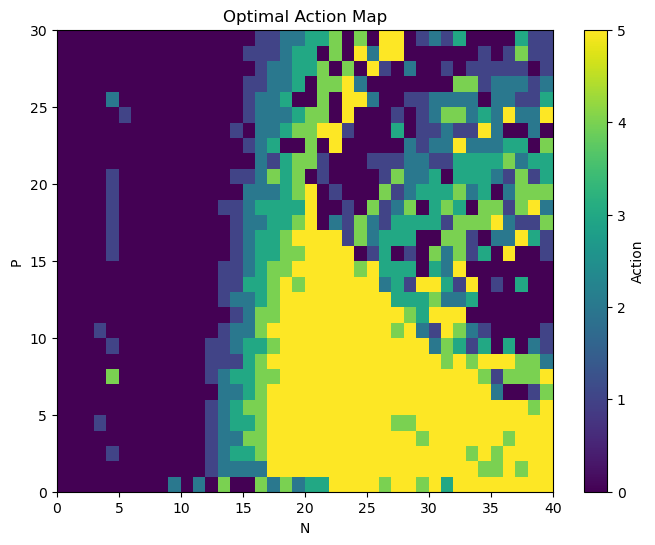

In [19]:
sim.sdp()
fig = sim.plot_sdp()
sim.P_mat[20, 0]

### Economic Model

np.float64(0.0)

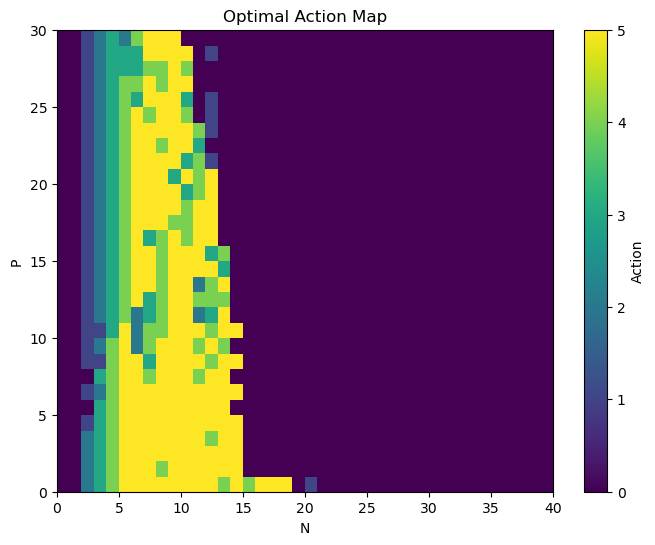

In [46]:
sim.sdp_economic(50, 5*50)
fig = sim.plot_sdp()
sim.P_mat[20, 10]

In [47]:
from tqdm import tqdm

for i in tqdm(range(sim.num_states)):
    for _ in range(100):
        sim.model_pop(N_0 = int(sim.S_mat[i,0]), P_0=int(sim.S_mat[i,1]))

for i in tqdm(range(sim.num_states)):
    for _ in range(100):
        sim.model_pop(cull = False, N_0 = int(sim.S_mat[i,0]), P_0=int(sim.S_mat[i,1]))

100%|██████████| 1271/1271 [00:12<00:00, 100.46it/s]


In [32]:
sim.reset_lists()

In [34]:
# Find initial conditions to plot

initial_indices = []
for idx, (n, p) in enumerate(zip(sim.N_list['managed'], sim.P_list['managed'])):
    if n[0] == 20 and p[0] == 10:
        initial_indices.append(idx)
print(initial_indices)

initial_indices = []
for idx, (n, p) in enumerate(zip(sim.N_list['unmanaged'], sim.P_list['unmanaged'])):
    if n[0] == 20 and p[0] == 10:
        initial_indices.append(idx)
print(initial_indices)

[126000, 126001, 126002, 126003, 126004, 126005, 126006, 126007, 126008, 126009, 126010, 126011, 126012, 126013, 126014, 126015, 126016, 126017, 126018, 126019, 126020, 126021, 126022, 126023, 126024, 126025, 126026, 126027, 126028, 126029, 126030, 126031, 126032, 126033, 126034, 126035, 126036, 126037, 126038, 126039, 126040, 126041, 126042, 126043, 126044, 126045, 126046, 126047, 126048, 126049, 126050, 126051, 126052, 126053, 126054, 126055, 126056, 126057, 126058, 126059, 126060, 126061, 126062, 126063, 126064, 126065, 126066, 126067, 126068, 126069, 126070, 126071, 126072, 126073, 126074, 126075, 126076, 126077, 126078, 126079, 126080, 126081, 126082, 126083, 126084, 126085, 126086, 126087, 126088, 126089, 126090, 126091, 126092, 126093, 126094, 126095, 126096, 126097, 126098, 126099, 126100, 126101, 126102, 126103, 126104, 126105, 126106, 126107, 126108, 126109, 126110, 126111, 126112, 126113, 126114, 126115, 126116, 126117, 126118, 126119, 126120, 126121, 126122, 126123, 126124,

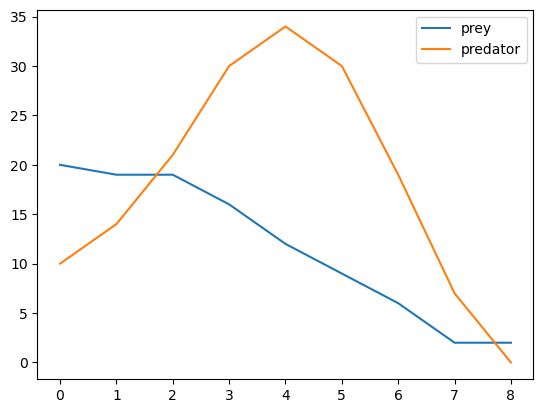

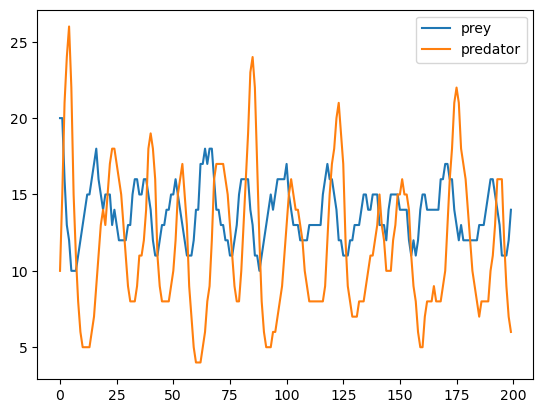

In [26]:
fig = sim.plot('managed',126000)
fig = sim.plot('unmanaged',102148)

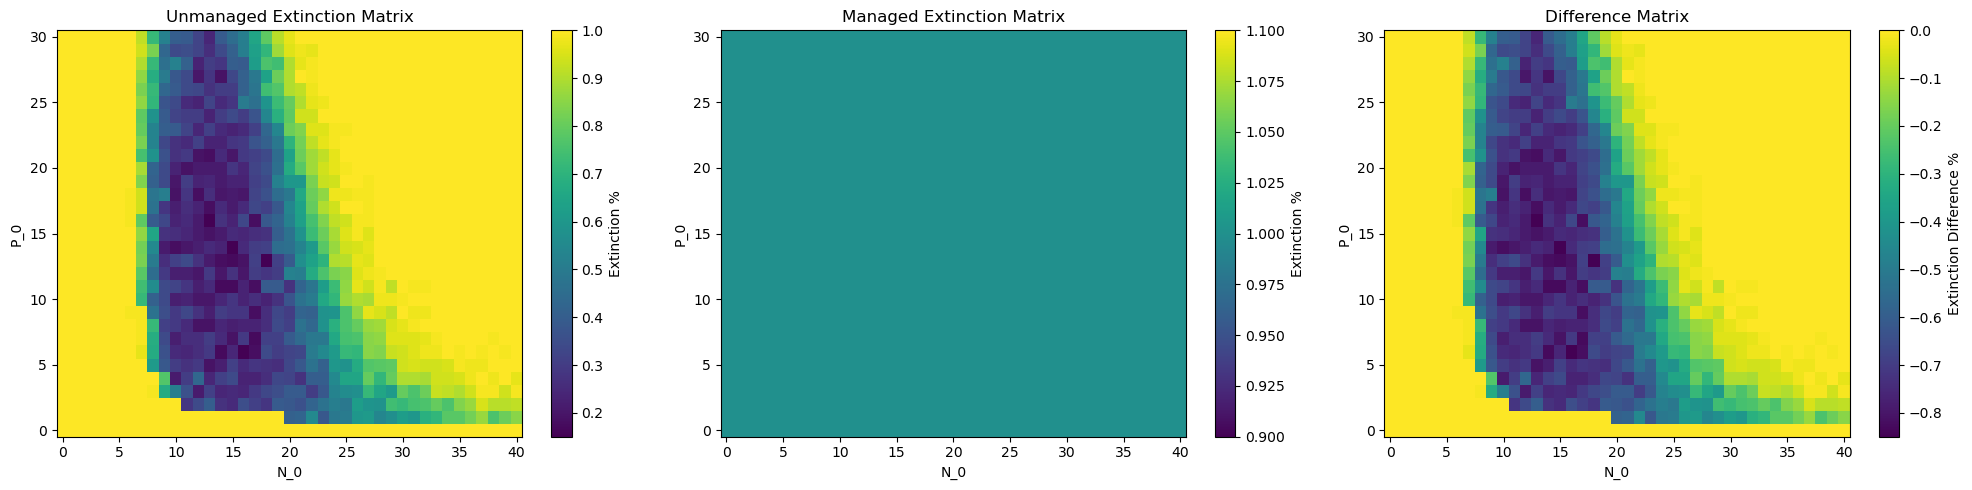

In [48]:
sim.plot_extinction_matrices_percents()

C:\Users\druid\AppData\Local\Temp\ipykernel_33016\1794351248.py:408: RuntimeWarning: divide by zero encountered in divide
  (self.ext_mats['unmanaged'][1].T-self.ext_mats['managed'][1].T)/
C:\Users\druid\AppData\Local\Temp\ipykernel_33016\1794351248.py:408: RuntimeWarning: invalid value encountered in divide
  (self.ext_mats['unmanaged'][1].T-self.ext_mats['managed'][1].T)/


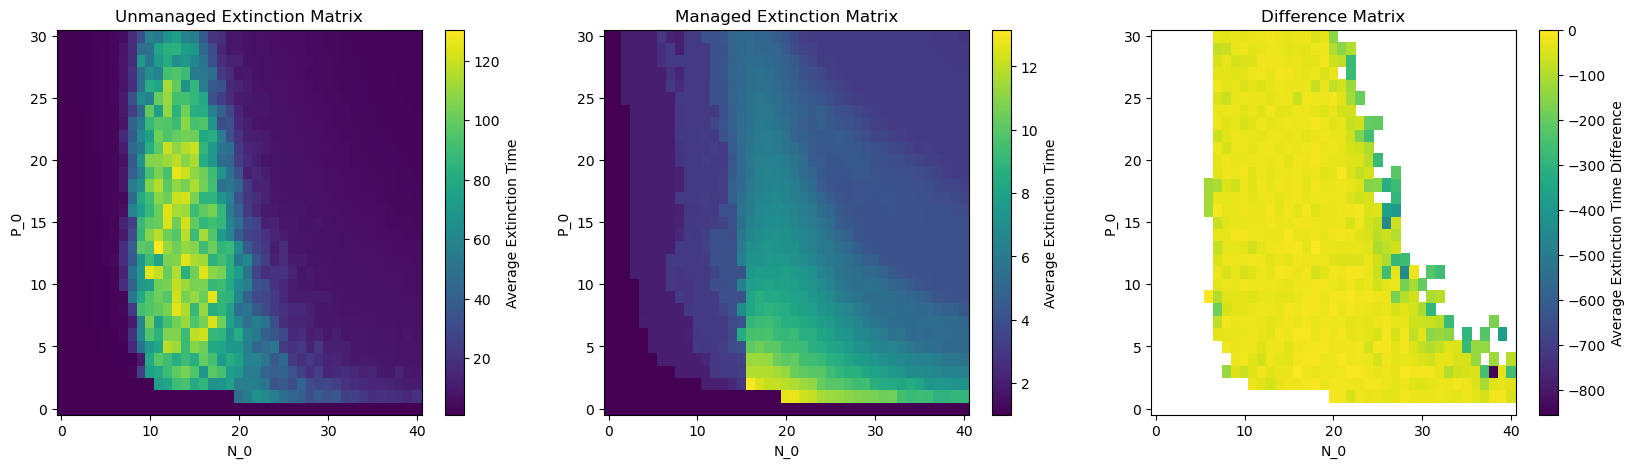

In [50]:
fig, (ax1, ax2, ax3) = sim.plot_extinction_matrices_times()

In [59]:
sim.ext_mats['managed'][0].T[1]

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [226]:
print(f'Unmanaged: {len(sim.extinct['unmanaged'])/(sim.num_states*100)}')
print(f'Managed: {len(sim.extinct['managed'])/(sim.num_states*100)}')
print(f'Average Improvement: {np.mean(sim.ext_mats['unmanaged']/100 - sim.ext_mats['managed']/100)}')

Unmanaged: 0.7671439811172305
Managed: 0.5486309992132179
Average Improvement: 0.2185129819040126


In [196]:
print(np.mean(sim.extinct['unmanaged']))
print(np.mean(sim.extinct['managed']))

15.881963816869051
5.006037486913998


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
# Unmanaged extinction matrix
c1 = ax1.pcolor(np.arange(sim.N_max+1), np.arange(sim.P_max+1), sim.ext_mats['unmanaged'].T/100, shading='auto',)
fig.colorbar(c1, ax=ax1, label="Extinction %")
ax1.set_xlabel("N_0")
ax1.set_ylabel("P_0")
ax1.set_title("Unmanaged Extinction Matrix")

# Managed extinction matrix
c2 = ax2.pcolor(np.arange(sim.N_max+1), np.arange(sim.P_max+1), sim.ext_mats['managed'].T/100, shading='auto')
fig.colorbar(c2, ax=ax2, label="Extinction %")
ax2.set_xlabel("N_0")
ax2.set_ylabel("P_0")
ax2.set_title("Managed Extinction Matrix")

c3 = ax3.pcolor(np.arange(sim.N_max+1), np.arange(sim.P_max+1), (sim.ext_mats['unmanaged']-sim.ext_mats['managed']).T/100, shading='auto')
fig.colorbar(c3, ax=ax3, label="Extinction Difference %")
ax3.set_xlabel("N_0")
ax3.set_ylabel("P_0")
ax3.set_title("Difference Matrix")

plt.tight_layout()
plt.show()

# Plot How Long Until Extinction on Average

# Some More Questions
1. What is the average number of caribou and prey among time series?
2. Can we tweak the SDP so as to not so greatly dampen the effect. Right now, it seems a little bit unatural, what if we have constant swings but not so large